In [6]:
import tensorflow as tf
import os
import time
import pandas as pd
from matplotlib import pyplot as plt
from IPython import display
from PIL import Image
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Mean
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LambdaCallback



In [7]:
input_image = Image.open('D:/dataset/UAS/before.jpeg')
input_image = tf.cast(input_image, tf.float32)
real_image = Image.open('D:/dataset/UAS/after.jpeg')
real_image = tf.cast(real_image, tf.float32)

In [8]:
input_image = tf.image.resize(input_image, [256, 256])
real_image = tf.image.resize(real_image, [256, 256])

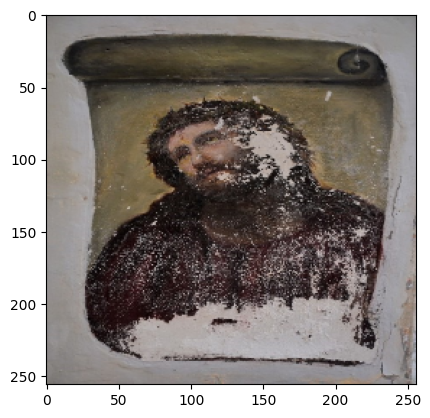

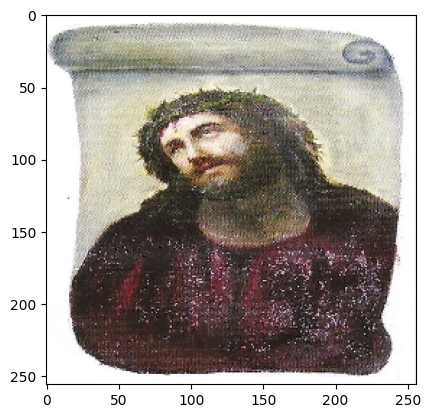

In [9]:
inp, re = input_image, real_image

plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [10]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

In [11]:
def random_crop(input_image, real_img):
    stacked_image = tf.stack([input_image, real_img], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    return cropped_image[0], cropped_image[1]

In [12]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [13]:
@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    
    return input_image, real_image

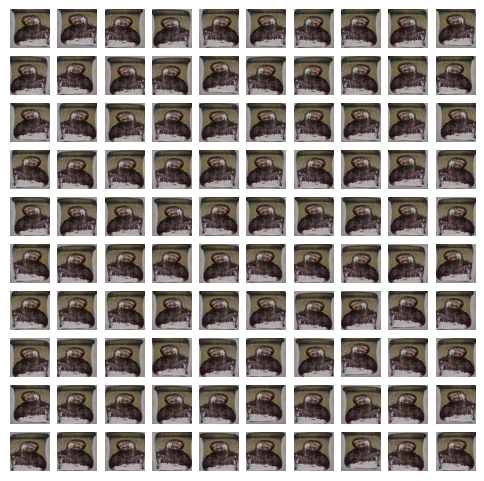

In [14]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Calculate the number of rows and columns needed for 100 subplots
n = int(np.ceil(np.sqrt(100)))

plt.figure(figsize=(6, 6))
for i in range(100):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(n, n, i+1)  # Change this to use n, not 2
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [15]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [16]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [17]:
BUFFER_SIZE = 1000  # Set this to the size of your dataset
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(([input_image], [real_image]))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [18]:
test_dataset = tf.data.Dataset.from_tensor_slices(([input_image], [real_image]))
test_dataset = test_dataset.batch(BATCH_SIZE)

test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [19]:
OUTPUT_CHANNELS = 3

In [20]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [21]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)


(1, 128, 128, 3)


In [22]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

upmodel = upsample(3, 4)
up_result = upmodel(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [23]:
def generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), 
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')
    x = inputs
    s = []
    concat = tf.keras.layers.Concatenate()
    for down in down_stack:
        x = down(x)
        s.append(x)
    s = reversed(s[:-1])
    for up, sk in zip(up_stack, s):
        x = up(x)
        x = concat([x, sk])
    last = last(x)
    return tf.keras.Model(inputs=inputs, outputs=last)


In [24]:
# Assuming generator is a Keras model
generator = generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_4 (Sequential)   (None, 64, 64, 128)          131584    ['sequential_3[0][0]']        
                                                                                                  
 sequential_5 (Sequential)   (None, 32, 32, 256)          525312    ['sequential_4[0][0]']        
                                                                                              

In [25]:
lambda_ = 100

In [26]:
lambda_gan = 1.0  
lambda_l1 = 100.0  

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss * lambda_gan + l1_loss * lambda_l1
    return total_gen_loss, gan_loss, l1_loss


In [27]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()

In [28]:
discriminator = Discriminator()
discriminator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate_2 (Concatenate  (None, 256, 256, 6)          0         ['input_image[0][0]',         
 )                                                                   'target_image[0][0]']        
                                                                                                  
 sequential_21 (Sequential)  (None, 128, 128, 64)         6144      ['concatenate_2[0][0]'] 

In [29]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def discriminator_loss(disc_real_output, disc_general_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_general_output), disc_general_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss
    

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [32]:
checkpoint_dir = 'D:/dataset/UAS'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [46]:
def generate_image(model, input_image, target):
    prediction = model(input_image)[0]
    
    plt.figure(figsize=(15,5))

    display_list = [input_image, target, target]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Normalize the image to [0, 1] and squeeze before plotting
        img = tf.squeeze(display_list[i])
        img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
        plt.imshow(img)
        plt.axis('off')
    plt.show()

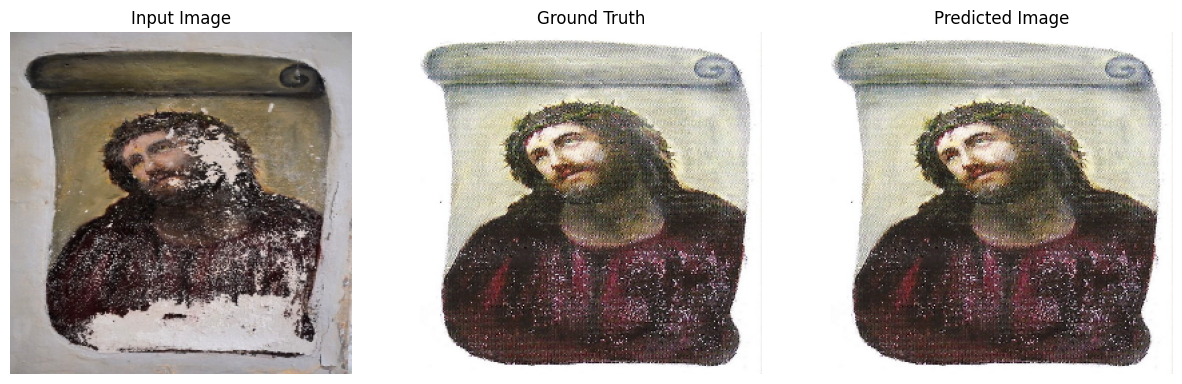

In [47]:
for example_input, example_target in test_dataset.take(1):
    generate_image(generator, example_input, example_target)


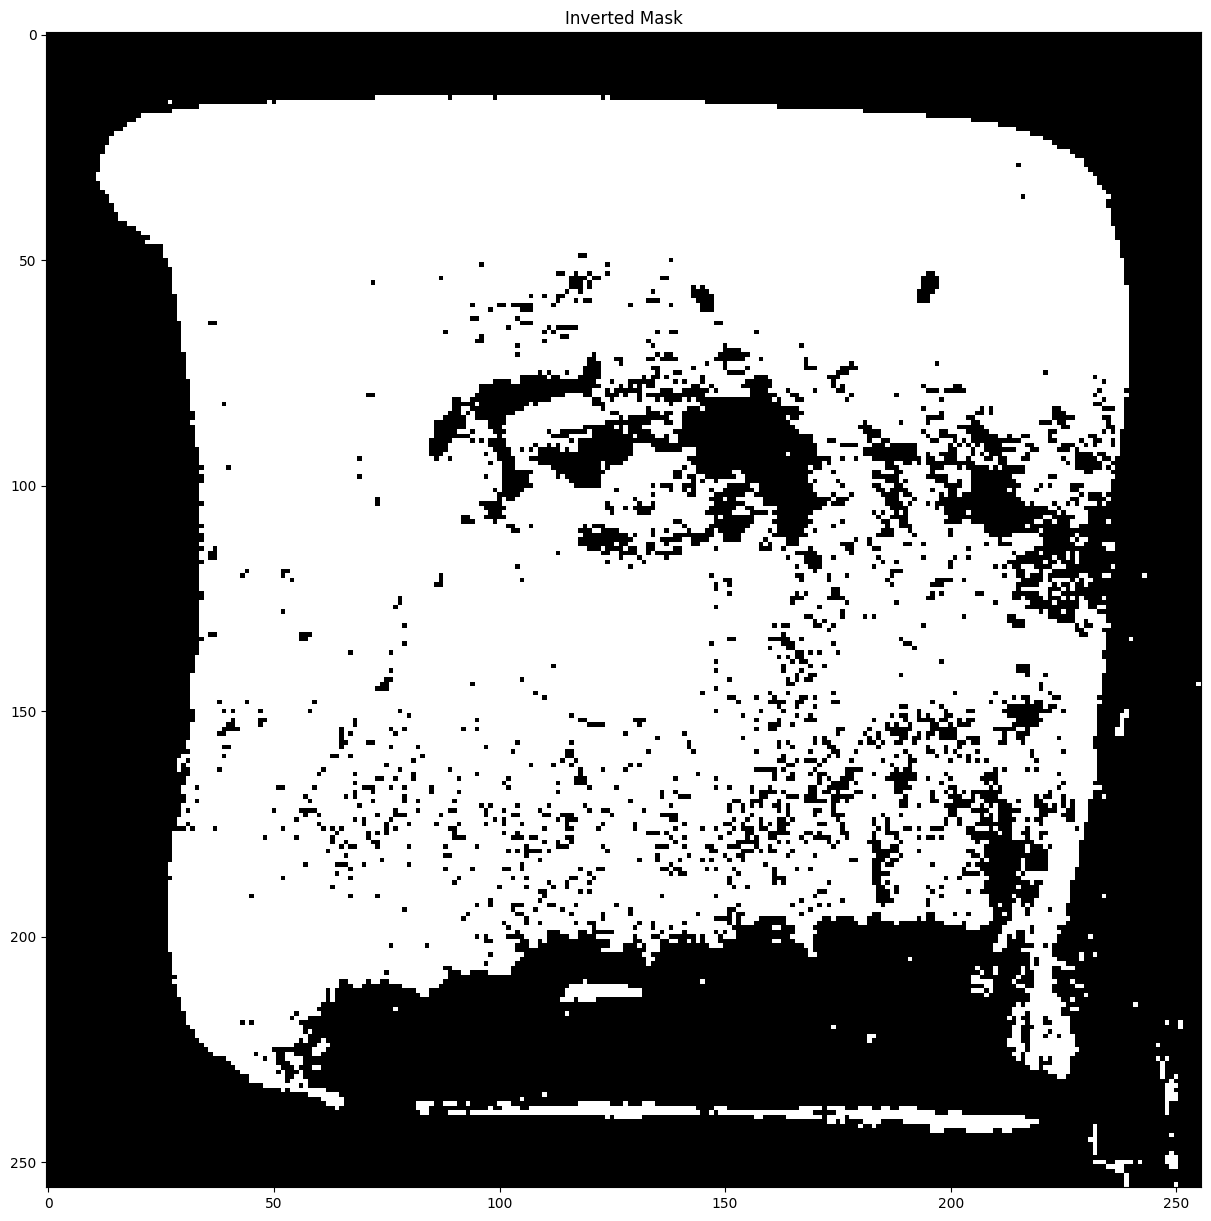

In [35]:
img = input_image

# Convert the image to a binary mask based on average color
average_color = np.mean(img, axis=(0, 1))
mask = np.all(img >= average_color, axis=-1)

# Invert the mask
inverted_mask = 1.0 - mask.astype(float)

# Apply inverted mask to image
masked_img = img * inverted_mask[:, :, np.newaxis]

# Plot the results
_, axes = plt.subplots(1, 1, figsize=(15, 15))

# Plot binary mask on the second axis
axes.imshow(inverted_mask, cmap='gray')
axes.set_title("Inverted Mask")

# Show the plot
plt.show()

In [36]:
example_input.shape

TensorShape([1, 256, 256, 3])

In [37]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
import sys
sys.path.append('D:/dataset/UAS')
from pconv_model import PConv2D

channels = 3  # replace with actual number of channels

shape = (IMG_HEIGHT, IMG_WIDTH, channels)
input_image = Input(shape=(shape[0], shape[1], shape[2]))
inverted_mask = Input(shape=(shape[0], shape[1], shape[2]))
output_img, output_mask1 = PConv2D(8, kernel_size=(7,7), strides=(2,2))([input_image, inverted_mask])
output_img, output_mask2 = PConv2D(16, kernel_size=(5,5), strides=(2,2))([output_img, output_mask1])
output_img, output_mask3 = PConv2D(32, kernel_size=(5,5), strides=(2,2))([output_img, output_mask2])
output_img, output_mask4 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask3])
output_img, output_mask5 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask4])
output_img, output_mask6 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask5])
output_img, output_mask7 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask6])
output_img, output_mask8 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask7])

# Create model
model = Model(
    inputs=[input_image, inverted_mask], 
    outputs=[
        output_img, output_mask1, output_mask2, 
        output_mask3, output_mask4, output_mask5,
        output_mask6, output_mask7, output_mask8
    ])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary of the model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 p_conv2d (PConv2D)          [(None, 128, 128, 8),        2360      ['input_2[0][0]',             
                              (None, 128, 128, 8)]                   'input_3[0][0]']             
                                                                                                  
 p_conv2d_1 (PConv2D)        [(None, 64, 64, 16),         6416      ['p_conv2d[0][0]',      

In [38]:
formatted_img = np.expand_dims(masked_img, 0) / 255
formatted_mask = np.expand_dims(mask, 0)
formatted_mask = np.expand_dims(formatted_mask, axis=-1)
formatted_mask = np.repeat(formatted_mask, channels, axis=-1)
print(f"Original Mask Shape: {formatted_mask.shape} - Max value in mask: {np.max(formatted_mask)}")

output_img, o1, o2, o3, o4, o5, o6, o7, o8 = model.predict([formatted_img, formatted_mask])

Original Mask Shape: (1, 256, 256, 3) - Max value in mask: True
1/1 [==============================] - 0s 363ms/step


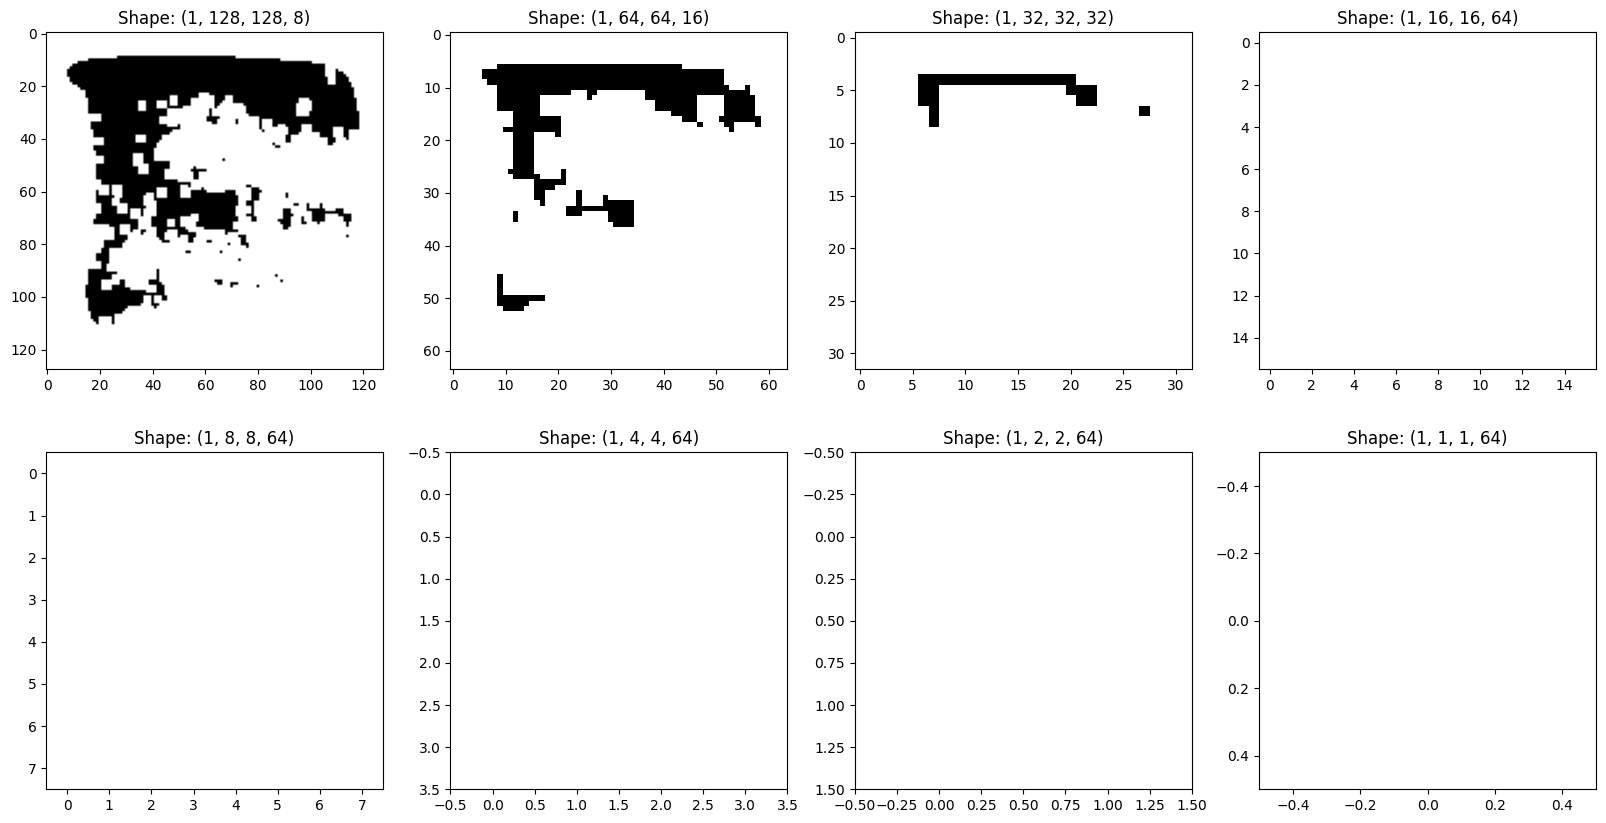

In [39]:
_, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0][0].imshow(o1[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][1].imshow(o2[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][2].imshow(o3[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][3].imshow(o4[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][0].imshow(o5[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][1].imshow(o6[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][2].imshow(o7[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][3].imshow(o8[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][0].set_title(f"Shape: {o1.shape}")
axes[0][1].set_title(f"Shape: {o2.shape}")
axes[0][2].set_title(f"Shape: {o3.shape}")
axes[0][3].set_title(f"Shape: {o4.shape}")
axes[1][0].set_title(f"Shape: {o5.shape}")
axes[1][1].set_title(f"Shape: {o6.shape}")
axes[1][2].set_title(f"Shape: {o7.shape}")
axes[1][3].set_title(f"Shape: {o8.shape}")
plt.show()

In [40]:
EPOCHS = 100

In [41]:
import datetime
log_dir="D:/dataset/UAS/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [42]:
import tensorflow as tf 

@tf.function
def _train_step(input_image, target, step, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step)
        tf.summary.scalar('disc_loss', disc_loss, step=step)

In [43]:
def fit(train_ds, epoch, test_ds):
    for example_input, example_target in test_ds.take(1):
        generate_image(generator, example_input, example_target)
    for step, (input_image, target) in train_ds.repeat().take(steps_per_epoch).enumerate():
        _train_step(input_image, target, step, epoch)
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)
    print()
    for example_input, example_target in test_ds.take(1):
        generate_image(generator, example_input, example_target)
        print("EPOCHS: ", epoch)

    for n, (input_image, target) in test_ds.enumerate():
        print('.', end='', flush=True)
        if (n+1) % 10 == 0:
            print()
        train_step(input_image, target, n, epoch)
    print()

    if (epoch + 1) % 10 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)


In [44]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for step, input_image in enumerate(dataset):
            loss = _train_step(input_image, step, epoch)
            print ('Step {}, Loss: {}'.format(step, loss))

        # Save the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

NameError: name 'dataset' is not defined